In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, r2_score, mean_squared_error
)
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [56]:
df = pd.read_csv('streamworks_user_data.csv')

In [57]:
df.head(3)

,user_id,age,gender,signup_date,last_active_date,country,subscription_type,average_watch_hours,mobile_app_usage_pct,complaints_raised,received_promotions,referred_by_friend,is_churned,monthly_fee
0,1001.0,56.0,Other,02-04-25,13-07-25,France,Standard,42.6,77.4,1.0,No,No,1.0,10.99
1,1002.0,69.0,Male,02-01-23,13-07-25,India,Basic,65.3,98.0,4.0,No,Yes,1.0,5.99
2,1003.0,46.0,Male,21-08-22,13-07-25,UK,Premium,40.1,47.8,0.0,No,Yes,1.0,13.99


# 1. Data Exploration & Cleaning

In [58]:
print(df.isnull().sum())

user_id                   2
age                       3
gender                    1
signup_date               2
last_active_date          2
country                   3
subscription_type         3
average_watch_hours       4
mobile_app_usage_pct      2
complaints_raised         3
received_promotions       3
referred_by_friend        3
is_churned                1
monthly_fee             145
dtype: int64


In [59]:
# Handle missing values
df['age'].fillna(df['age'].median(), inplace=True)
df['monthly_fee'].fillna(df.groupby('subscription_type')['monthly_fee'].transform('median'), inplace=True)
df['average_watch_hours'].fillna(df['average_watch_hours'].median(), inplace=True)
df['mobile_app_usage_pct'].fillna(df['mobile_app_usage_pct'].median(), inplace=True)

In [60]:
df.dropna(subset=['signup_date', 'last_active_date'], inplace=True)

In [61]:
df['signup_date'] = pd.to_datetime(df['signup_date'], format='%d-%m-%y')
df['last_active_date'] = pd.to_datetime(df['last_active_date'], format='%d-%m-%y')

In [62]:
# Check cleaned data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1496 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               1494 non-null   float64       
 1   age                   1496 non-null   float64       
 2   gender                1496 non-null   object        
 3   signup_date           1496 non-null   datetime64[ns]
 4   last_active_date      1496 non-null   datetime64[ns]
 5   country               1493 non-null   object        
 6   subscription_type     1493 non-null   object        
 7   average_watch_hours   1496 non-null   float64       
 8   mobile_app_usage_pct  1496 non-null   float64       
 9   complaints_raised     1493 non-null   float64       
 10  received_promotions   1493 non-null   object        
 11  referred_by_friend    1493 non-null   object        
 12  is_churned            1495 non-null   float64       
 13  monthly_fee           1

# 2. Feature Engineering

In [63]:
# Calculate tenure in days
df['tenure_days'] = (df['last_active_date'] - df['signup_date']).dt.days

# Create 'is_loyal' flag (tenure > 180 days)
df['is_loyal'] = np.where(df['tenure_days'] > 180, 1, 0)

# Calculate watch time per fee ratio
df['watch_per_fee_ratio'] = df['average_watch_hours'] / df['monthly_fee']

# Create 'heavy_mobile_user' flag
df['heavy_mobile_user'] = np.where(df['mobile_app_usage_pct'] > 70, 1, 0)

# Encode categorical variables
df = pd.get_dummies(df, columns=['gender', 'subscription_type', 'received_promotions', 'referred_by_friend'])

# Display new features
df[['tenure_days', 'is_loyal', 'watch_per_fee_ratio', 'heavy_mobile_user']].head()

,tenure_days,is_loyal,watch_per_fee_ratio,heavy_mobile_user
0,102,0,3.876251,1
1,923,1,10.901503,1
2,1057,1,2.866333,0
3,668,1,0.414582,0
4,715,1,3.273273,0


# 3. Statistical Analysis

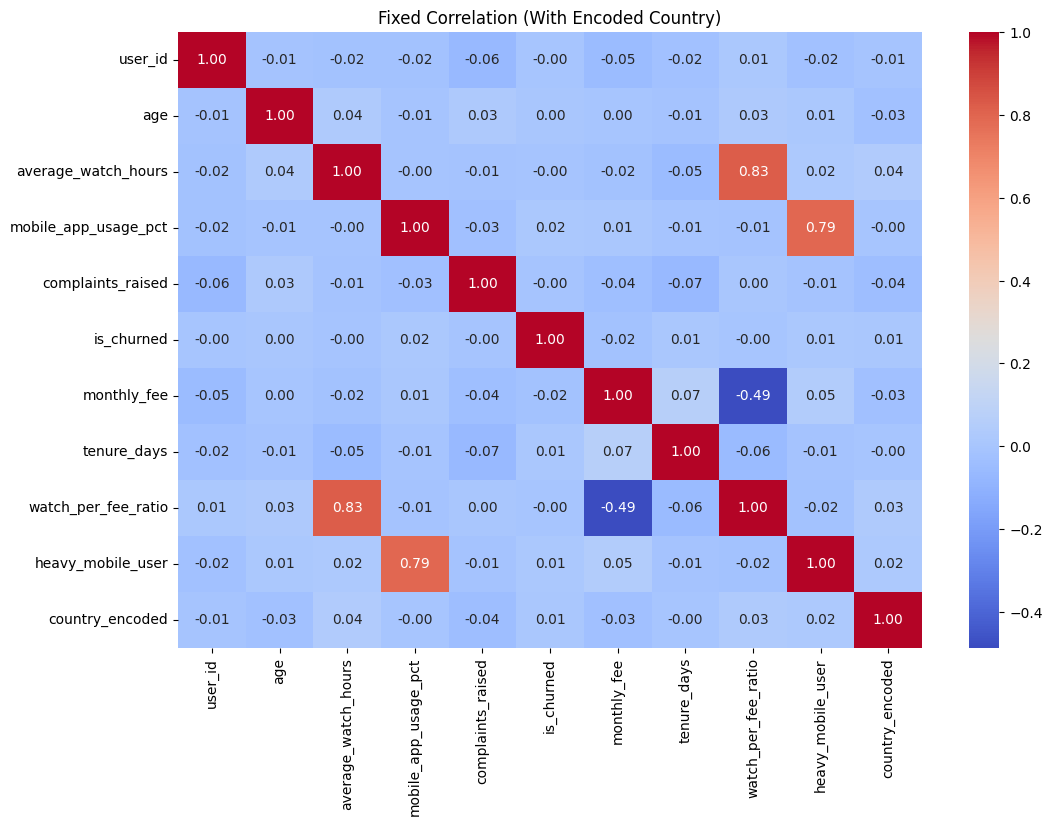

In [64]:
df['country_encoded'] = LabelEncoder().fit_transform(df['country'])
numerical_with_country = df.select_dtypes(include=['int64','float64']).drop('is_loyal', axis=1)

corr_with_country = numerical_with_country.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_with_country, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Fixed Correlation (With Encoded Country)")
plt.show()

In [65]:
# Chi-square test for promotions vs churn
contingency_table = pd.crosstab(df['received_promotions_Yes'], df['is_churned'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square test (Promotions vs Churn): p-value = {p:.4f}")

Chi-square test (Promotions vs Churn): p-value = 0.1078


In [66]:
# T-test for watch time (churned vs retained)
churned = df[df['is_churned'] == 1]['average_watch_hours']
retained = df[df['is_churned'] == 0]['average_watch_hours']
t_stat, p_val = ttest_ind(churned, retained)
print(f"T-test (Watch Time): p-value = {p_val:.4f}")

T-test (Watch Time): p-value = 0.8496


In [67]:
print("Top 3 Anti-Churn Correlations:")
print(corr_with_country['is_churned'].sort_values(ascending=True).head(3))

print()

print("Top 3 Watch Time Drivers:")
print(corr_with_country['average_watch_hours'].sort_values(ascending=False).head(3))

Top 3 Anti-Churn Correlations:
monthly_fee           -0.020981
complaints_raised     -0.004927
average_watch_hours   -0.004907
Name: is_churned, dtype: float64

Top 3 Watch Time Drivers:
average_watch_hours    1.000000
watch_per_fee_ratio    0.825456
country_encoded        0.039918
Name: average_watch_hours, dtype: float64


# 4. Predictive Modeling
## 4.1 Logistic Regression

In [68]:
target = 'is_churned'

# Drop non-numeric and irrelevant columns
X = df.drop(columns=['user_id', 'signup_date', 'last_active_date', 'is_churned'])
X = X.select_dtypes(include=['int64', 'float64', 'uint8'])  # Only keep numeric columns

y = df[target]

In [69]:
print("Before cleaning:")
print(f"- NaN in features: {X.isnull().sum().sum()}")
print(f"- NaN in target: {y.isnull().sum()}")

Before cleaning:
- NaN in features: 3
- NaN in target: 1


In [70]:
# Drop rows with missing target
valid_indices = y.notna()
X_clean = X[valid_indices]
y_clean = y[valid_indices]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

In [71]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [72]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [73]:
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

print("Model Evaluation:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")

Model Evaluation:
              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87       229
         1.0       0.00      0.00      0.00        70

    accuracy                           0.77       299
   macro avg       0.38      0.50      0.43       299
weighted avg       0.59      0.77      0.66       299

ROC-AUC: 0.5157


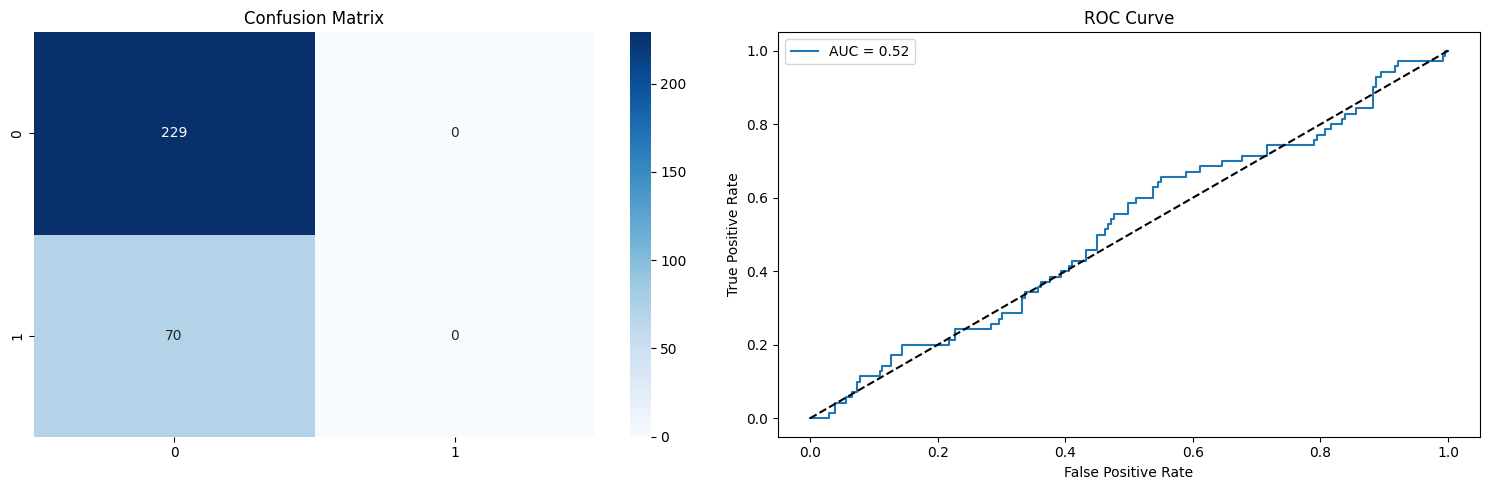

Top Predictive Features:
                Feature  Coefficient
6              is_loyal     0.106936
4           monthly_fee    -0.096582
7   watch_per_fee_ratio    -0.084440
1   average_watch_hours     0.066203
8     heavy_mobile_user     0.034301
9       country_encoded     0.019791
0                   age     0.015207
2  mobile_app_usage_pct     0.004779
3     complaints_raised     0.001862
5           tenure_days     0.001006


In [74]:
# Confusion Matrix & ROC Curve
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')

fpr, tpr, _ = roc_curve(y_test, y_prob)
ax[1].plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].set_title('ROC Curve')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend()

plt.tight_layout()
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': logreg.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("Top Predictive Features:")
print(feature_importance.head(10))

## 4.2 Linear Regression

In [75]:
target_lr = 'average_watch_hours'

# Drop irrelevant and target columns
X_lr = df.drop(columns=[
    'user_id', 'signup_date', 'last_active_date', 'average_watch_hours', 'is_churned'
])

y_lr = df[target_lr]

In [76]:
# Drop rows with missing target values
valid_idx_lr = y_lr.notna()
X_lr = X_lr[valid_idx_lr]
y_lr = y_lr[valid_idx_lr]

# Keep only numeric columns
X_lr = X_lr.select_dtypes(include=['int64', 'float64', 'uint8'])

In [77]:
# Impute and scale
imputer = SimpleImputer(strategy='median')
X_lr_imputed = imputer.fit_transform(X_lr)

scaler = StandardScaler()
X_lr_scaled = scaler.fit_transform(X_lr_imputed)

In [78]:
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(
    X_lr_scaled, y_lr, test_size=0.2, random_state=42  # Changed to 80/20 as per your choice
)

In [79]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_lr_train, y_lr_train)

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

y_lr_pred = linreg.predict(X_lr_test)

r2 = r2_score(y_lr_test, y_lr_pred)
rmse = np.sqrt(mean_squared_error(y_lr_test, y_lr_pred))

print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R²: 0.8635
RMSE: 8.1211


Top Predictive Features (Linear Regression):
                Feature  Coefficient
6   watch_per_fee_ratio    24.414772
3           monthly_fee    11.525141
4           tenure_days    -0.727348
7     heavy_mobile_user     0.659122
8       country_encoded     0.464537
1  mobile_app_usage_pct    -0.369316
0                   age     0.297331
5              is_loyal     0.243174
2     complaints_raised    -0.080302


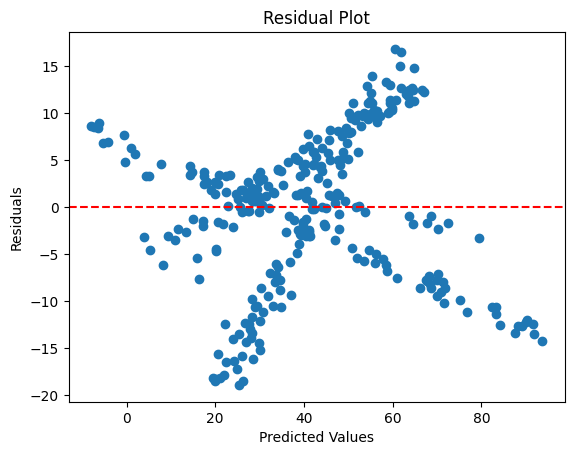

In [80]:
feature_importance_lr = pd.DataFrame({
    'Feature': X_lr.columns,
    'Coefficient': linreg.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Top Predictive Features (Linear Regression):")
print(feature_importance_lr.head(10))

# Residual Plot
plt.scatter(y_lr_pred, y_lr_test - y_lr_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()